In [35]:
from sklearn.model_selection import train_test_split
import os
import sklearn.datasets as skd

In [36]:
import sklearn.datasets as skd
data_dir = r'C:\Users\heihe\Desktop\Malaysia-Legal-Doc-Classification\code_revised\combinned_data_txt'
labels = os.listdir(data_dir)
legal_doc = skd.load_files(data_dir, categories=labels)

print("Number of legal case doc: " + str(len(legal_doc.data)))
print("Number of diffrent categories: " + str(len(legal_doc.target_names)))

legal_doc.target_names

Number of legal case doc: 80
Number of diffrent categories: 12


['Abetment',
 'Charges',
 'Common intention',
 'Corruption',
 'Dangerous Drugs',
 'Defence',
 'Firearms',
 'Money Laundering',
 'Murder',
 'Offences',
 'Rape',
 'Sedition']

## Define training function, splitting the training and testing doc

In [37]:
from sklearn.model_selection import train_test_split
import time


def train(classifier, X, y):
    start = time.time()
    # X_train, X_test, y_train, y_test = train_test_split(
    #     X, y, test_size=0.2, random_state=42)

    print("X_train: ", len(X_train))
    print("y_train: ", y_train)
    print("X_test: ", len(X_test))
    print("y_test: ", y_test)

    classifier.fit(X_train, y_train)
    end = time.time()

    print("Accuracy: " + str(classifier.score(X_test, y_test)) +
          ", Time duration: " + str(end - start))
    return classifier


## Not splitting the data but load the separated data corpus

In [38]:
def size_mb(docs):
    return sum(len(s.encode('utf-8')) for s in docs) / 1e6

In [39]:
def load_testing_data (test_dir):
    legal_test = skd.load_files(test_dir, categories=labels, encoding='utf-8')
    return legal_test


In [40]:
def load_training_data(train_dir):
    legal_train = skd.load_files(
        train_dir,  categories=labels, encoding='utf-8')
    return legal_train

In [41]:
data_train = load_training_data(
    r'C:\Users\heihe\Desktop\Malaysia-Legal-Doc-Classification\code_revised\training_data_txt')
data_test = load_testing_data(
    r'C:\Users\heihe\Desktop\Malaysia-Legal-Doc-Classification\code_revised\testing_data_txt')

print('test data loaded')

data_train_size_mb = size_mb(str(data_train.data))
data_test_size_mb = size_mb(str(data_test.data))

print("%d documents - %0.3fMB (training set)" % (
    len(data_train.data), data_train_size_mb))
print("%d documents - %0.3fMB (test set)" % (
    len(data_test.data), data_test_size_mb))
    
print(f"{len(labels)} categories")


test data loaded
62 documents - 3.013MB (training set)
18 documents - 0.916MB (test set)
12 categories


### visualize the data corpus

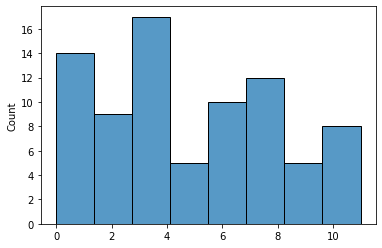

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.histplot(legal_doc.target)
plt.show()


### Printing the size of the corpus, not correct, now it is all the corpus

In [43]:
# def size_mb(docs):
#     return sum(len(s.encode('utf-8')) for s in docs) / 1e6


# data_train_size_mb = size_mb(str(legal_train.data))
# data_test_size_mb = size_mb(str(legal_train.data))

# print("%d documents - %0.3fMB (training set)" % (
#     len(legal_doc.data), data_train_size_mb))
# print("%d documents - %0.3fMB (test set)" % (
#     len(legal_doc.data), data_test_size_mb))
# print("%d categories" % len(labels))
# print()


# Feature Extraction

## TF-idf + Vectorizer =  a subset of n-grams for model by using the vocabulary parameter.

In [44]:
import numpy as np
import pandas as pd
import scipy.sparse as sp

from time import time
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, auc
from sklearn.naive_bayes import MultinomialNB
from sklearn.calibration import CalibratedClassifierCV

vectorizer = TfidfVectorizer(ngram_range=(
        1, 2), lowercase=True, sublinear_tf=True, max_df=0.5, stop_words='english')

def tf_vectorizer_train(data_train):
    t0 = time()
    print("Extracting features from the dataset using a vectorizer with  unigrams and bigrams")
    X_train = vectorizer.fit_transform(
        (open(f, encoding='latin1').read() for f in data_train.filenames))
    print("done in %fs" % (time() - t0))
    print("n_samples: %d, n_features: %d" % X_train.shape)
    assert sp.issparse(X_train)
    y_train = data_train.target
    return X_train, y_train


In [45]:
def tf_vectorizer_test(data_test):
    print("Extracting features from the dataset using the same vectorizer")
    t0 = time()
    X_test = vectorizer.transform(
        (open(f, encoding='utf-8').read() for f in data_test.filenames))
    y_test = data_test.target
    print("done in %fs" % (time() - t0))
    print("n_samples: %d, n_features: %d" % X_test.shape)
    return X_test, y_test


In [46]:
## for word embedding
import gensim
import gensim.downloader as gensim_api


benchmark different classifiers:

In [52]:
def benchmark(clf_class, params, name):
    print("parameters:", params)
    t0 = time()
    X_train, y_train = tf_vectorizer_train(data_train)
    X_test, y_test = tf_vectorizer_test(data_test)
    clf = clf_class(**params).fit(X_train, y_train)
    calibrator = CalibratedClassifierCV(clf, cv='prefit')
    clf = calibrator.fit(X_train, y_train)
    print("done in %fs" % (time() - t0))

    if hasattr(clf, 'coef_'):
        print("Percentage of non zeros coef: %f" %
              (np.mean(clf.coef_ != 0) * 100))
    print("Predicting the outcomes of the testing set")
    t0 = time()
    pred = clf.predict(X_test)
    predicted_prob = clf.predict_proba(X_test)
    print("done in %fs" % (time() - t0))

    print("Classification report on test set for classifier:")
    print(clf)
    print()

    ## Accuracy, Precision, Recall
    accuracy = metrics.accuracy_score(y_test, pred)
    auc = metrics.roc_auc_score(y_test, predicted_prob,
                                multi_class="ovr")
    print("Accuracy:",  round(accuracy, 2))
    print("Auc:", round(auc, 2))
    print("Detail:")
    svm_classification_report_save = classification_report(y_test, pred,
          target_names=data_test.target_names, zero_division=1)
    print(svm_classification_report_save)

    cm = confusion_matrix(y_test, pred)
    print("Confusion matrix:")
    print(cm)

    # Show confusion matrix
    plt.matshow(cm)
    plt.title('Confusion matrix of the %s classifier' % name)
    plt.colorbar()

    y_test_array = pd.get_dummies(y_test, drop_first=False).values

    fig, ax = plt.subplots(nrows=1, ncols=2)


    ## Plot roc
    for i in range(len(labels)):
        fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:, i],
                                                predicted_prob[:, i])
        ax[0].plot(fpr, tpr, lw=3,
                label='{0} (area={1:0.2f})'.format(labels[i],
                                                    metrics.auc(fpr, tpr))
                )
    ax[0].plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
    ax[0].set(xlim=[-0.05, 1.0], ylim=[0.0, 1.05],
            xlabel='False Positive Rate',
            ylabel="True Positive Rate (Recall)",
            title="Receiver operating characteristic")
    ax[0].legend(loc="lower right")
    ax[0].grid(True)

    ## Plot precision-recall curve
    for i in range(len(labels)):
        precision, recall, thresholds = precision_recall_curve(
            y_test_array[:, i], predicted_prob[:, i])
        ax[1].plot(recall, precision, lw=3,
                label='{0} (area={1:0.2f})'.format(labels[i],
                                                   metrics.auc(recall, precision))
                )
    ax[1].set(xlim=[0.0, 1.05], ylim=[0.0, 1.05], xlabel='Recall',
            ylabel="Precision", title="Precision-Recall curve")
    ax[1].legend(loc="best")
    ax[1].grid(True)
    plt.show()


### Benchmark a Linear Classifier - SGDClassifier

 Using a linear classifier...
parameters: {'loss': 'hinge', 'penalty': 'l2', 'max_iter': 50, 'n_iter_no_change': 5, 'alpha': 0.001, 'fit_intercept': True, 'random_state': 42}
Extracting features from the dataset using a vectorizer with  unigrams and bigrams
done in 1.371092s
n_samples: 62, n_features: 187271
Extracting features from the dataset using the same vectorizer
done in 0.202035s
n_samples: 18, n_features: 187271
done in 1.751846s
Predicting the outcomes of the testing set
done in 0.030007s
Classification report on test set for classifier:
CalibratedClassifierCV(base_estimator=SGDClassifier(alpha=0.001, max_iter=50,
                                                    random_state=42),
                       cv='prefit')

Accuracy: 0.56
Auc: 0.79
Detail:
                  precision    recall  f1-score   support

        Abetment       0.00      0.00      0.00         1
         Charges       1.00      1.00      1.00         2
Common intention       0.00      0.00      0.00      

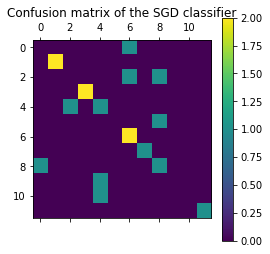

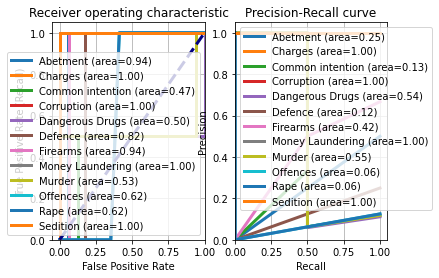

In [53]:
print(" Using a linear classifier...")
parameters = {
    'loss': 'hinge',
    'penalty': 'l2',
    'max_iter': 50,
    'n_iter_no_change' : 5,
    'alpha': 1e-3,
    'fit_intercept': True,
    'random_state' : 42
}

benchmark(SGDClassifier, parameters, 'SGD')


### Benchmark a MultinomialNB Classifier

Using a MultinomialNB classifier...
parameters: {'alpha': 0.01}
done in 0.106780s
Percentage of non zeros coef: 100.000000
Predicting the outcomes of the testing set
done in 0.013506s
Classification report on test set for classifier:
MultinomialNB(alpha=0.01)

                  precision    recall  f1-score   support

        Abetment       0.00      0.00      0.00         1
         Charges       1.00      1.00      1.00         2
Common intention       0.33      0.50      0.40         2
      Corruption       1.00      1.00      1.00         2
 Dangerous Drugs       0.33      0.50      0.40         2
         Defence       1.00      0.00      0.00         1
        Firearms       0.33      0.50      0.40         2
Money Laundering       1.00      1.00      1.00         1
          Murder       0.50      0.50      0.50         2
        Offences       1.00      0.00      0.00         1
            Rape       1.00      0.00      0.00         1
        Sedition       1.00      1.00     

C:\Users\heihe\anaconda3\envs\MyDocClass\lib\site-packages\sklearn\utils\deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)


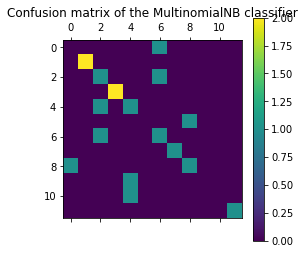

In [70]:
print("Using a MultinomialNB classifier...")
parameters = {'alpha': 0.01}
benchmark(MultinomialNB, parameters, 'MultinomialNB')


Reduce dimension can be one of the consideration

In [ ]:
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import TruncatedSVD

# Reduce dimensions
svd = TruncatedSVD(n_components)
normalizer = Normalizer(copy=False)


In [98]:
print (len(data_train.data))

62


In [99]:
pd.DataFrame(data_train.target).value_counts()

1     8
4     8
6     8
2     7
8     6
3     5
5     4
9     4
11    4
0     3
7     3
10    2
dtype: int64

# testing

In [100]:
# Order of labels in `target_names` can be different from `categories`
target_names = data_train.target_names

# Split a train set and test set
y_train, y_test = data_train.target, data_test.target

print("Extracting features from the test data using the same vectorizer")
X_test = vectorizer.transform(data_test.data)
# X_test = lsa.fit_transform(X_test)


Extracting features from the test data using the same vectorizer


# LogisticRegression()

In [101]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.svm import SVC

from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer, CountVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)


LogisticRegression()

In [102]:
lr_pred = lr_clf.predict(X_train.toarray())
train_score = accuracy_score(y_train, lr_pred) * 100
print(f"Train accuracy score: {train_score:.2f}%")

lr_pred = lr_clf.predict(X_test.toarray())
test_score = accuracy_score(y_test, lr_pred) * 100
print(f"Test accuracy score: {test_score:.2f}%")

Train accuracy score: 93.55%
Test accuracy score: 33.33%


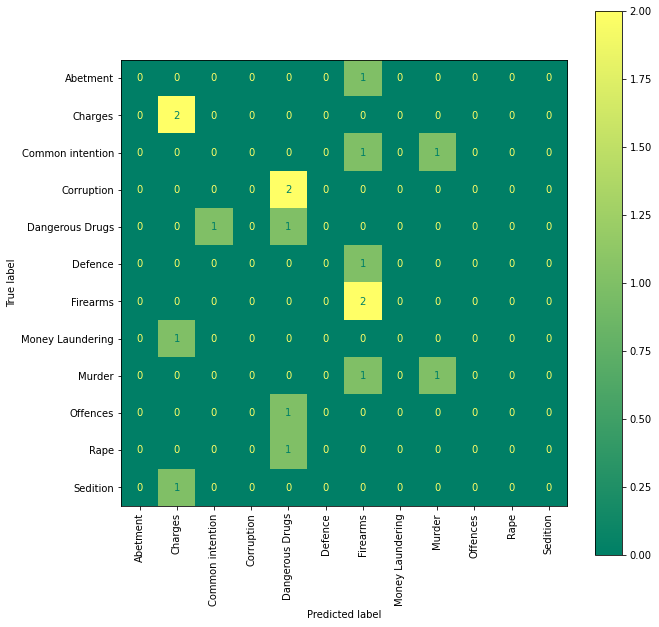

In [103]:
# lr_pred = lr_clf.predict(X_test.toarray())
cm = confusion_matrix(y_test, lr_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=data_train.target_names)


# NOTE: Fill all variables here with default values of the plot_confusion_matrix
fig, ax = plt.subplots(figsize=(10, 10))
disp = disp.plot(xticks_rotation='vertical', ax=ax, cmap='summer')

plt.show()


In [104]:
pd.DataFrame(classification_report(y_test, lr_pred, output_dict=True)).T

C:\Users\heihe\anaconda3\envs\MyDocClass\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\heihe\anaconda3\envs\MyDocClass\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\heihe\anaconda3\envs\MyDocClass\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
0,0.000000,0.000000,0.000000,1.000000
1,0.500000,1.000000,0.666667,2.000000
2,0.000000,0.000000,0.000000,2.000000
3,0.000000,0.000000,0.000000,2.000000
4,0.200000,0.500000,0.285714,2.000000
5,0.000000,0.000000,0.000000,1.000000
6,0.333333,1.000000,0.500000,2.000000
7,0.000000,0.000000,0.000000,1.000000
8,0.500000,0.500000,0.500000,2.000000
9,0.000000,0.000000,0.000000,1.000000


# Naive Bayes (Gaussian)

In [105]:
nb_clf = GaussianNB()
nb_clf.fit(X_train.toarray(), y_train)


GaussianNB()

In [106]:
nb_pred = nb_clf.predict(X_train.toarray())
train_score = accuracy_score(y_train, nb_pred) * 100
print(f"Train accuracy score: {train_score:.2f}%")

nb_pred = nb_clf.predict(X_test.toarray())
test_score = accuracy_score(y_test, nb_pred) * 100
print(f"Test accuracy score: {test_score:.2f}%")


Train accuracy score: 100.00%
Test accuracy score: 38.89%


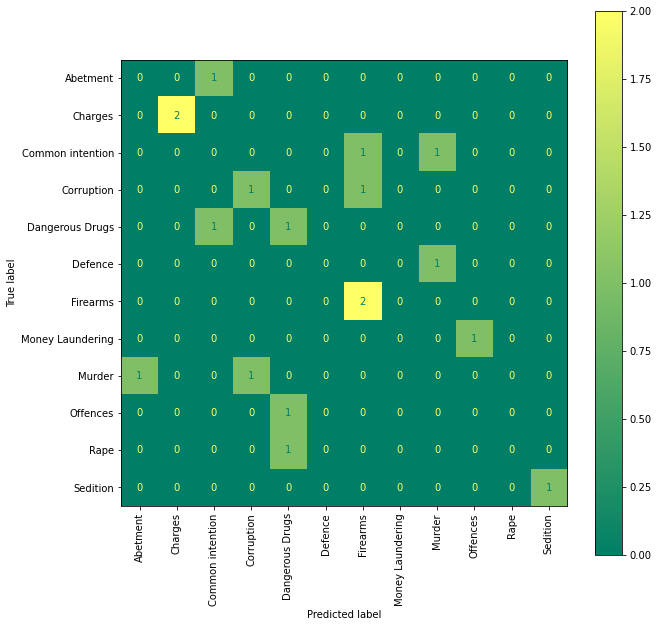

In [107]:
# nb_pred = nb_clf.predict(X_test.toarray())
cm = confusion_matrix(y_test, nb_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=data_train.target_names)


# NOTE: Fill all variables here with default values of the plot_confusion_matrix
fig, ax = plt.subplots(figsize=(10, 10))
disp = disp.plot(xticks_rotation='vertical', ax=ax, cmap='summer')

plt.show()


In [108]:
pd.DataFrame(classification_report(y_test, nb_pred, output_dict=True)).T

C:\Users\heihe\anaconda3\envs\MyDocClass\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\heihe\anaconda3\envs\MyDocClass\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\heihe\anaconda3\envs\MyDocClass\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
0,0.000000,0.000000,0.000000,1.000000
1,1.000000,1.000000,1.000000,2.000000
2,0.000000,0.000000,0.000000,2.000000
3,0.500000,0.500000,0.500000,2.000000
4,0.333333,0.500000,0.400000,2.000000
5,0.000000,0.000000,0.000000,1.000000
6,0.500000,1.000000,0.666667,2.000000
7,0.000000,0.000000,0.000000,1.000000
8,0.000000,0.000000,0.000000,2.000000
9,0.000000,0.000000,0.000000,1.000000


# Naive Bayes (Multinomial)

In [109]:
mb_clf = MultinomialNB()
mb_clf.fit(X_train.toarray(), y_train)


MultinomialNB()

In [110]:
mb_pred = nb_clf.predict(X_train.toarray())
train_score = accuracy_score(y_train, mb_pred) * 100
print(f"Train accuracy score: {train_score:.2f}%")

mb_pred = mb_clf.predict(X_test.toarray())
test_score = accuracy_score(y_test, mb_pred) * 100
print(f"Test accuracy score: {test_score:.2f}%")


Train accuracy score: 100.00%
Test accuracy score: 33.33%


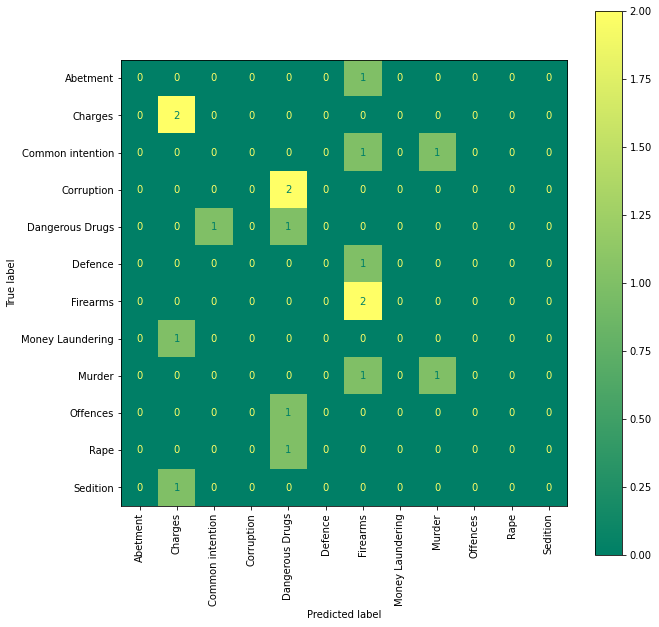

In [111]:
# nb_pred = nb_clf.predict(X_test.toarray())
cm = confusion_matrix(y_test, mb_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=data_train.target_names)


# NOTE: Fill all variables here with default values of the plot_confusion_matrix
fig, ax = plt.subplots(figsize=(10, 10))
disp = disp.plot(xticks_rotation='vertical', ax=ax, cmap='summer')

plt.show()


In [112]:
pd.DataFrame(classification_report(y_test, mb_pred, output_dict=True)).T


C:\Users\heihe\anaconda3\envs\MyDocClass\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\heihe\anaconda3\envs\MyDocClass\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\heihe\anaconda3\envs\MyDocClass\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
0,0.000000,0.000000,0.000000,1.000000
1,0.500000,1.000000,0.666667,2.000000
2,0.000000,0.000000,0.000000,2.000000
3,0.000000,0.000000,0.000000,2.000000
4,0.200000,0.500000,0.285714,2.000000
5,0.000000,0.000000,0.000000,1.000000
6,0.333333,1.000000,0.500000,2.000000
7,0.000000,0.000000,0.000000,1.000000
8,0.500000,0.500000,0.500000,2.000000
9,0.000000,0.000000,0.000000,1.000000


# Support Vector Machine

In [113]:
svm_clf = SVC()
svm_clf.fit(X_train.toarray(), y_train)


SVC()

In [114]:
svm_pred = svm_clf.predict(X_train.toarray())
train_score = accuracy_score(y_train, svm_pred) * 100
print(f"Train accuracy score: {train_score:.2f}%")

svm_pred = svm_clf.predict(X_test.toarray())
test_score = accuracy_score(y_test, svm_pred) * 100
print(f"Test accuracy score: {test_score:.2f}%")


Train accuracy score: 100.00%
Test accuracy score: 27.78%


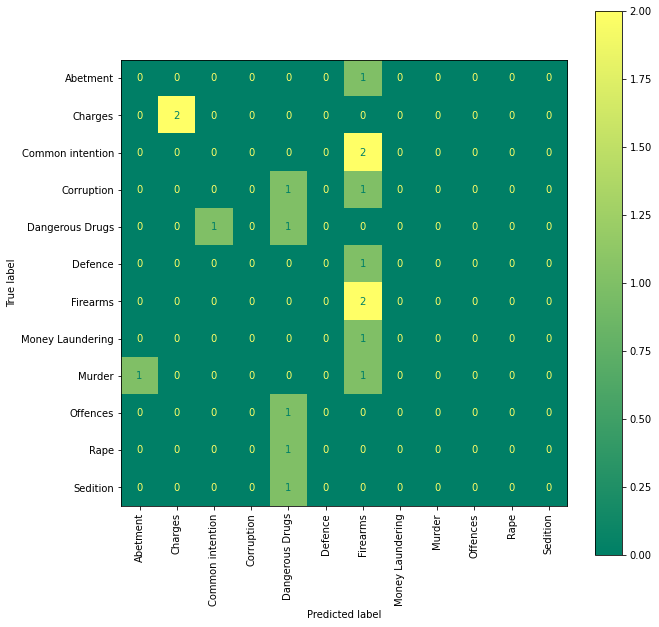

In [115]:
svm_pred = svm_clf.predict(X_test.toarray())
cm = confusion_matrix(y_test, svm_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=data_train.target_names)


# NOTE: Fill all variables here with default values of the plot_confusion_matrix
fig, ax = plt.subplots(figsize=(10, 10))
disp = disp.plot(xticks_rotation='vertical', ax=ax, cmap='summer')

plt.show()

## legal

In [116]:
, from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

trial1 = Pipeline([('vectorizer', TfidfVectorizer()),
                  ('classifier', MultinomialNB())])

train(trial1, legal_doc.data, legal_doc.target)


X_train:  64
y_train:  [ 2 10  2  5  9  3  9  2  3  1  0 11  0  4  1  5  9  3  0  3  6  2 11 10
  9 11  2  1  6  4  8  7  4  2  6  6  4  8  8  8  3  7  4  8  8  8  4 11
  6  1  7  3  7  3  2  4  4 11  1  5  2  9  6  4]
X_test:  16
y_test:  [10  6  5  1  1  1  5  1  6  0  6  6  4  1  8  2]
Accuracy: 0.4375, Time duration: 0.20204496383666992


Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('classifier', MultinomialNB())])

# SVM

## 20NewsGroup

In [117]:
from sklearn.datasets import fetch_20newsgroups
labels = ["rec.autos", "rec.motorcycles",
          "rec.sport.baseball", "rec.sport.hockey"]
raw_docs, y = fetch_20newsgroups(
    subset='all', return_X_y=True, categories=labels)
# print(raw_docs)